In [12]:
import pandas as pd
import numpy as np
import glob
import os
import datetime
import matplotlib.pyplot as plt
from functools import reduce


%matplotlib inline

# Functions

### Data loading

In [13]:
def load_data_description(filename_description):
    
    # load data
    df_descr = pd.read_excel(filename_description, engine='openpyxl')
    
    # strip all spaces
    for c in df_descr.columns:
        df_descr[c] = df_descr[c].str.strip()
        
    return df_descr

In [14]:
def load_and_describe_data(files, description):
    
    # make a copy of the description df in order to leave the original untouched
    df_descr = description.copy()
    
    # initiate dict to store data
    dfs = {}

    # initiate columns in the description dataframe to store additional information
    for col in ['filename','body_type','name', 'targets','features','start','end','period','n_records','n_records_target','n_records_no_NaN']:
        df_descr[col] = None
    df_descr.set_index('Database', inplace=True)

    # body types
    body_types = ['Aquifer', 'Water_Spring', 'River', 'Lake']

    for f in files:
        
        # get name of the water body from the filename
        database = f.split('\\')[-1].replace('.csv','')
        
        # add filename to description dataframe
        df_descr.at[database, 'filename'] = f.split('raw\\')[-1]


        # load the data
        df = pd.read_csv(f)

        # drop rows for which all values are NaN
        df.dropna(how='all', axis=0, inplace=True)

        # fix inconsistent naming for some of the water bodies
        if database == 'Water_Spring_Madonna_di_Canneto':
            output = df_descr.loc[database, 'Output'].replace('Flow_Rate', 'Flow_Rate_Madonna_di_Canneto')
            df_descr.loc[database, 'Output'] = output
            #df.rename(columns={'Flow_Rate_Madonna_di_Canneto':'Flow_Rate'}, inplace=True)
        if database == 'Water_Spring_Lupa':
            output = df_descr.loc[database, 'Output'].replace('Flow_Rate', 'Flow_Rate_Lupa')
            df_descr.loc[database, 'Output'] = output
            #df.rename(columns={'Flow_Rate_Lupa': 'Flow_Rate'}, inplace=True)
        if database == 'Aquifer_Auser':            
            df.rename(columns={'Depth_to_Groundwater_CoS': 'Depth_to_Groundwater_COS'}, inplace=True)

        # add body type and name of the body to description
        body_type = [b for b in body_types if b in database][0]
        df_descr.at[database, 'body_type'] = body_type
        df_descr.at[database, 'name'] = database.replace(body_type, '')[1:]

        # get all the target names for the waterbody
        targets = df_descr.loc[database, 'Output'].split(',')
        targets = [t.strip() for t in targets]
        df_descr.at[database, 'targets'] = targets
        # check if all target columns are present in the data
        if not np.all([target in df.columns for target in targets]):
            print(database)
            print([target for target in targets if target not in df.columns])

        # get all features for the water body
        features = list(set(df.columns) - set(targets))
        df_descr.at[database, 'features'] = features

        # get start and end data of the data
        if 'Date' in df.columns:
            df['date_orig'] = df['Date'].copy()
            df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
            df_descr.at[database, 'start'] = df['Date'].min()
            df_descr.at[database, 'end'] = df['Date'].max()
            df_descr.at[database, 'period'] = df['Date'].max() - df['Date'].min() 

        # count the number of records
        df_descr.at[database, 'n_records'] = len(df)
        df_descr.at[database, 'n_records_target'] = len(df.dropna(subset=targets))
        df_descr.at[database, 'n_records_no_NaN'] = len(df.dropna())

        # store data in dictionary by water body name
        dfs[database] = df

    # count the number of features and targets
    df_descr['n_targets'] = df_descr['targets'].apply(len)
    df_descr['n_features'] = df_descr['features'].apply(len)

    df_descr.reset_index(inplace=True)
    
    return df_descr.sort_values(by='body_type'), dfs

In [15]:
def merge_data(dfs):
    data_list = [v for k, v in dfs.items()]
    df_all = reduce(lambda df1, df2: pd.merge(df1, df2, on='Date'), data_list)
    return df_all

### Plotting

In [16]:
def bar_plot(body_types, cols, suptitle=None, ylim=None, save=False):
    fig = plt.figure(figsize=(10,8))
    for i, body_type in enumerate(body_types):
        ax = fig.add_subplot(2,2,i+1)
        df_descr[df_descr['body_type']==body_type].set_index('name')[cols].plot(kind='bar', ax=ax)
        plt.title(body_type)
        plt.ylabel('N')
        plt.xlabel('')
    if ylim:
        plt.ylim(*ylim)
    if suptitle:    
        plt.suptitle(suptitle)
    plt.tight_layout()
    
    if save:
        plt.savefig('figs/' + suptitle.replace(' ','_') + '.pdf')
        plt.savefig('figs/' + suptitle.replace(' ','_') + '.png')

In [17]:
def plot_time_period(description, body_types, save=False):
    
    fig = plt.figure(figsize=(10,4))
    for i, body_type in enumerate(body_types):
        ax = fig.add_subplot(2,2,i+1)
        body_names = description[description['body_type']==body_type].name.unique()
        for j, b in enumerate(body_names):
            x = pd.date_range(description.set_index('name').loc[b,'start'],description.set_index('name').loc[b,'end'])
            y = [j+1]*len(x)
            plt.plot(x, y, linewidth=5)
        ax.set_yticks(range(1, len(body_names)+1))
        ax.set_yticklabels(list(body_names))
        plt.title(body_type)
        plt.xlim(pd.to_datetime('1997-01-01'),pd.to_datetime('2021-01-01'))
    plt.suptitle('Time period available data per water body')
    plt.tight_layout()
    
    if save:
        plt.savefig('figs/time_period.pdf')
        plt.savefig('figs/time_period.png')

In [18]:
def plot_data_availability(name, data, description, save=False):

    dff = data[name][description.set_index('Database').loc[name, 'features']].set_index('Date')
    dft = data[name][['Date'] + description.set_index('Database').loc[name, 'targets']].set_index('Date')
    colsf = sorted(dff.columns)
    colst = sorted(dft.columns)
    cols = colsf + colst
    fig = plt.figure(figsize=(10, 0.3*(len(cols)+1)))
    ax = plt.gca()
    for i, c in enumerate(colsf):
        (dff[c].dropna().notnull().astype(int)*(i+1)).plot(linestyle='', marker='.')
    plt.axhline(i+2, color='black', linestyle=':')
    for j, c in enumerate(colst):
        (dft[c].dropna().notnull().astype(int)*(j+i+3)).plot(linestyle='', marker='.')
    ax.set_yticks(range(1, len(cols)+2))
    labels = ax.set_yticklabels(colsf + ['    ........     '] + colst)
    plt.title('Target(s) and feature(s) availability for %s'%name)
    plt.grid(axis='y')
    
    date_min = data[name]['Date'].min()
    date_max = data[name]['Date'].max()
    plt.xlim(date_min+datetime.timedelta(weeks=-10), date_max+datetime.timedelta(weeks=10))
                          
    if save:
        plt.savefig('figs/' + name + '.pdf')
        plt.savefig('figs/' + name + '.png')

    return

In [19]:
def inspect_water_body(name, df_descr, dfs, save=False):

    feature_types = ['Rainfall', 'Volume','Temperature','Hydrometry','Depth','bla']
    
    targets = df_descr.set_index('Database').loc[name,'targets']
    features = df_descr.set_index('Database').loc[name,'features'][:]
    features.remove('Date')

    dfs[name].set_index('Date')[targets].plot(figsize=(15,5), linestyle='', marker='.')
    plt.title('Target(s)')
    if save:
        plt.savefig('figs/' + name + '_target.pdf')
        plt.savefig('figs/' + name + '_target.png')
    
    for ftype in feature_types:
        try:
            dfs[name].set_index('Date')[features].filter(regex='^%s'%ftype).plot(figsize=(15,5), linestyle='', marker='.')
            plt.title(ftype)
            if save:
                plt.savefig('figs/' + name + '_' + ftype + '.pdf')
                plt.savefig('figs/' + name + '_' + ftype + '.png')

        except TypeError:
            pass
        
    return

In [76]:
def inspect_yearly_monthly_pattern(name, dfs, col, save=False):
    # yearly pattern + monthly pattern

    fig = plt.figure(figsize=(15,8))
    fig.add_subplot(2,2,1)
    dfs[name].set_index('Date').loc['2018-01-01':'2019-01-01', col].plot(marker='.', linestyle='')
    plt.title('%s in 2018'%(col.replace('_',' ')))
    fig.add_subplot(2,2,2)
    dfs[name].set_index('Date').loc['2020-01-01':'2021-01-01', col].plot(marker='.', linestyle='')
    plt.title('%s in 2020'%(col.replace('_',' ')))
    fig.add_subplot(2,2,3)
    dfs[name].set_index('Date').loc['2018-01-01':'2018-06-01', col].plot(marker='.', linestyle='')
    for i in range(1,6):
        plt.axvline('2018-0%d-01'%i, color='gray')
    plt.title('%s for six months in 2018'%(col.replace('_',' ')))

    plt.tight_layout()
    
    if save:
        plt.savefig('figs/' + 'yearly_' + col + '.pdf')
        plt.savefig('figs/' + 'yearly_' + col + '.png')
    
    return


def inspect_monthly_weekly_pattern(name, dfs, col, save=False):
    # monthly pattern + weekly pattern

    fig = plt.figure(figsize=(15,8))
    fig.add_subplot(2,1,1)
    dfs[name].set_index('Date').loc['2018-01-01':'2018-02-26', col].plot(marker='.', linestyle='')
    for i in range(1,9):
        plt.axvline(pd.to_datetime('2018-01-01') + datetime.timedelta(weeks=i), color='gray')
    plt.axvline(pd.to_datetime('2018-02-01'), color='red', alpha=0.5)
    plt.title('%s in first 8 weeks in 2018'%(col.replace('_',' ')))
    fig.add_subplot(2,1,2)
    dfs[name].set_index('Date').loc['2020-01-06':'2020-03-02', col].plot(marker='.', linestyle='')
    for i in range(1,9):
        plt.axvline(pd.to_datetime('2020-01-06') + datetime.timedelta(weeks=i), color='gray')
    plt.axvline(pd.to_datetime('2020-02-01'), color='red', alpha=0.5)
    plt.title('%s in first 8 weeks in 2020'%(col.replace('_',' ')))
    
    plt.tight_layout()
    
    if save:
        plt.savefig('figs/' + 'weekly_' + col + '.pdf')
        plt.savefig('figs/' + 'weekly_' + col + '.png')

    
    return


In [143]:
def plot_matrix(values, labels, title, vmin=0, vmax=1, save=False):
    
    fig = plt.figure(figsize=(5,5))
    plt.imshow(values, vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.set_xticks(range(0, len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(0, len(labels)))
    ax.set_yticklabels(labels, rotation=0)
    plt.colorbar()
    plt.title(title)

    # save plot
    if save:
        plt.savefig('../figs/exploration_corr_%s.pdf'%(title.replace(' ','_')))

    return 

def plot_correlation_matrices(df, save=False):
    
    coltypes = ['^Rainfall','^Temperature', '^Depth_to_Groundwater', '^Hydrometry', '^Volume','^Flow_Rate']
    for ct in coltypes:
        cols = df.filter(regex=ct).columns
        if len(cols)>1:
            plot_matrix(df[cols].corr(), cols, ct.replace('^',''), vmin=-1, save=save)

# Settings

In [21]:
datadir = '../data/'
rawdir = os.path.join(datadir, 'raw')

In [22]:
body_types = ['Aquifer', 'Water_Spring', 'River', 'Lake']

### Load data

In [23]:
files = glob.glob(os.path.join(rawdir, '*.csv'))
filename_description = glob.glob(os.path.join(datadir, '*.xlsx'))[0]

In [24]:
description = load_data_description(filename_description)

df_descr, dfs = load_and_describe_data(files, description)
names = list(dfs.keys())

In [25]:
df_all = merge_data(dfs)

### Save columns

In [26]:
cols = [] 
for i, row in df_descr[['filename','targets','features']].iterrows():
    filename, targets, features = row
    cols = cols + [[filename, t, 'target'] for t in targets] + [[filename, f, 'feature'] for f in features]
dfcols = pd.DataFrame(cols, columns=['filename', 'colname', 'coltype'])
dfcols['name'] = dfcols['filename'].str.replace('.csv','')

In [782]:
dfcols.to_excel('../data/clean/column_description.xlsx', index=False)

### Inspect data

In [27]:
names

['Aquifer_Auser',
 'Aquifer_Doganella',
 'Aquifer_Luco',
 'Aquifer_Petrignano',
 'Lake_Bilancino',
 'River_Arno',
 'Water_Spring_Amiata',
 'Water_Spring_Lupa',
 'Water_Spring_Madonna_di_Canneto']

#### Number of targets and features

- The number of targets and features varies greatly between the different types of water bodies, which is expected due to the different nature of the water bodies
- Also for different water bodies of the same type, the number of targets and features can differ a lot
  - It seems like different water bodies of the same type might not be very comparable indicating that it might not be possible to create 1 model per type of water body

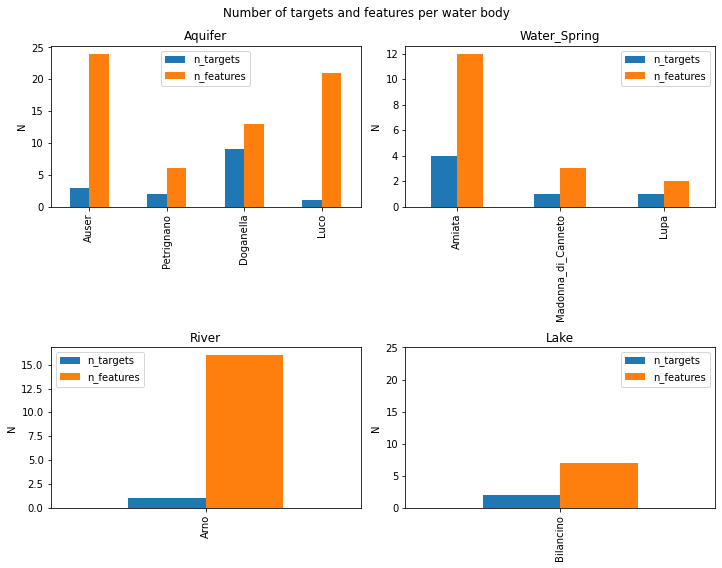

In [18]:
bar_plot(body_types, ['n_targets','n_features'], ylim=(0,25), suptitle='Number of targets and features per water body', save=True)

#### The number of records

Explanation of legend:
- n_records: number of the records in the dataset
- n_records_target: number of records in the dataset for which the target(s) is not NaN
- n_records_no_NaN: number of records in the dataset for which both the target(s) and the feature(s) are not NaN --> ie usable records

Observations:
- The number of available records varies greatly between water bodies
- Most records have one of more missing values. This greatly reduces the amount of data available for modelling

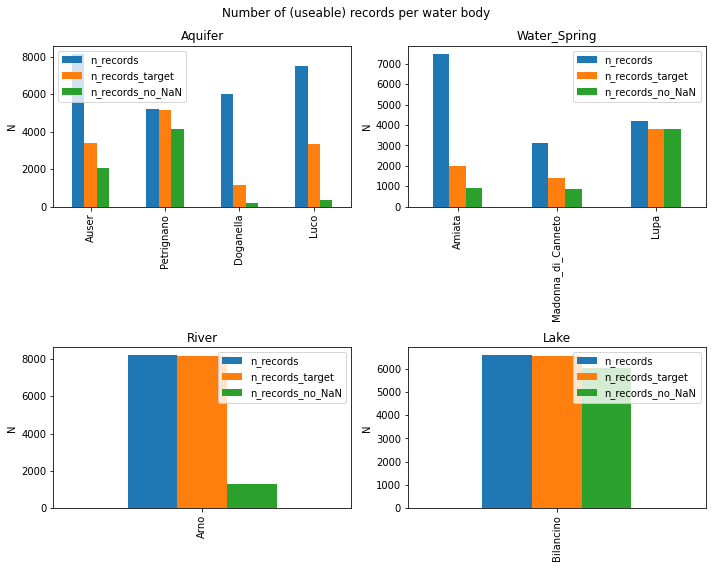

In [61]:
bar_plot(body_types, ['n_records', 'n_records_target', 'n_records_no_NaN'], suptitle='Number of (useable) records per water body', save=True)

#### Time period for which there is data

- For all water bodies there is data until dec 2020
- The start of data collection differs per water body
- Typically there are multiple years of data available

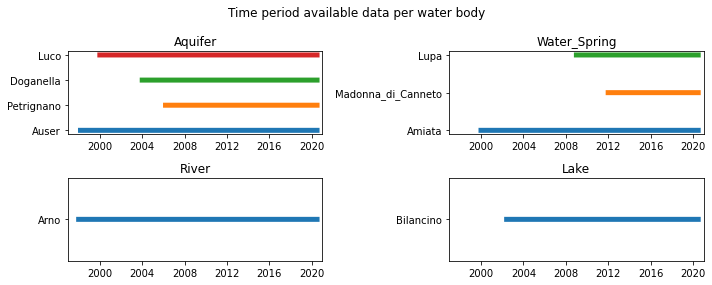

In [703]:
plot_time_period(df_descr, body_types)

#### Data availability per target/feature

There are many issues with the data availability:

- Not all features are available throughout the entire period for which target(s) are available, for instance (but not limited to)
  - Aquifer Doganella: targets: 2012-2020, volume related features available from 2016-2020, temperature/rainfall features available from 2004, but many missing values in the period after 2015 (rainfall only) 
  - River Arno: target: 1999-2020, features available from 2004 onwards. In the period 2018-2020 only 5 out of 15 features are available. No information is given on whether it will be possible to collect the missing features in the future
  
- The period in which there is data collected on the target variable(s) is often shorter than the period for which there is data for the feature(s), for instance (but not limited to) 
  - Water spring Amiata
  - Aquifer Auser.

- No recent measurements are available for the target variable
  - Aquifer Luco: data interupted around 2019. Also before the interuption there is no continuity in the data availability

- No recent measurements are available for all features
  - Water spring Madonna di Canneto: features unavailable since 2019. No information is given on whether these features will become available in the future again.
  



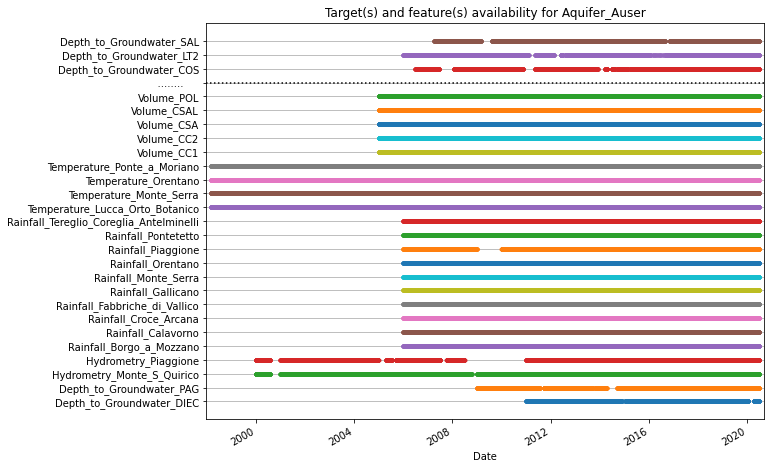

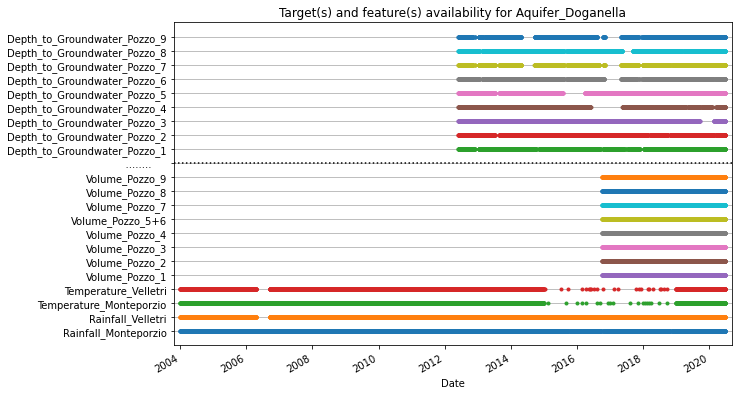

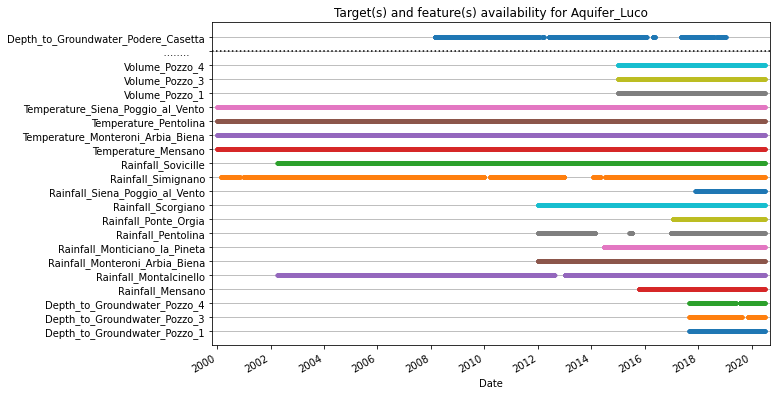

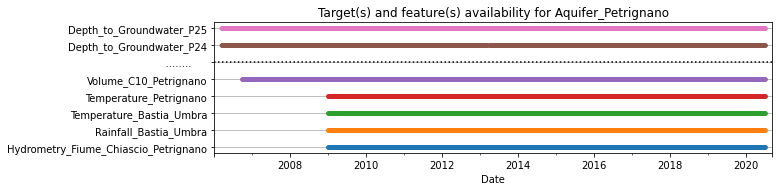

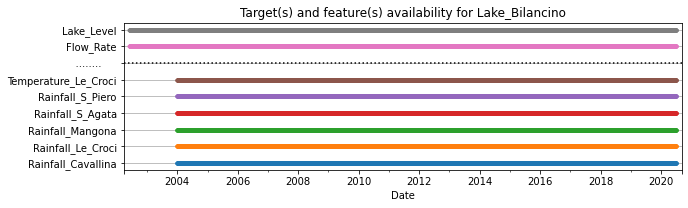

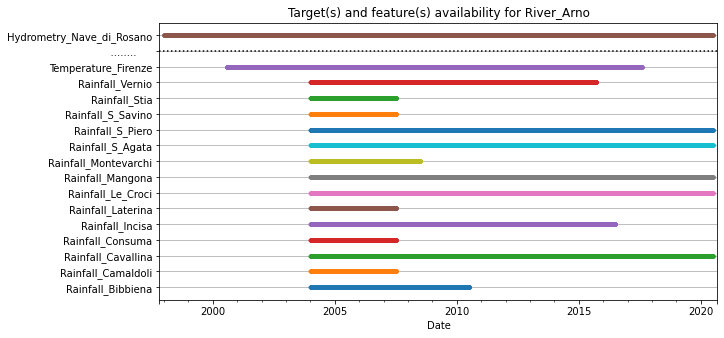

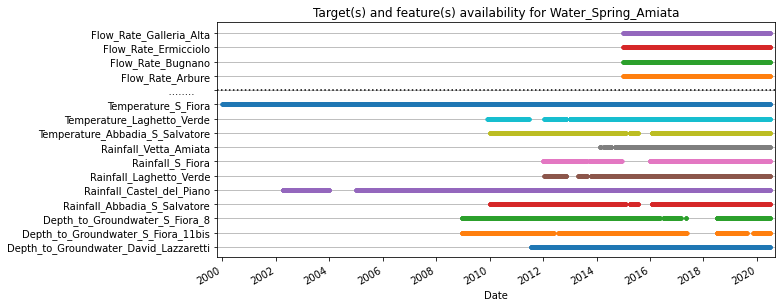

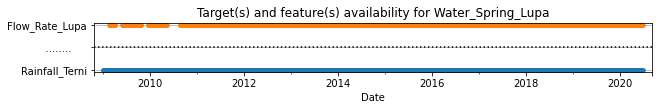

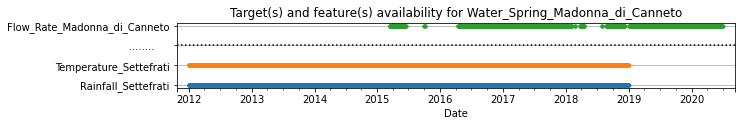

In [68]:
for name in names:
    plot_data_availability(name, dfs, df_descr, save=True)

## Conclusion

- Given the great diversity of (types of) water bodies and the amount of targets and features, it seems unlikely that it is possible to create 1 model per type of water body. A model per individual water model is recommended.
- Given the availabitly and continuity of both target and features, it will be challenging to create a model for all water bodies. 
- As a proof of concept, first the following water bodies will be modelled:
  - Aquifer Auser
  - Aquifer Petrignano
  - River Arno
  - Lake Bilancio
  - Water spring Amiata
- If modelling is succesfull, an investment needs to be made for improving data availability for the remaining water bodies, in order to create models for those in the future.

## Inspection of targets and features

### Aquifer Auser

Montly human interuptions can be seen in the data, as botht he depth to groundwater and the volume show monthly adjustments.

**Targets**
- All targets available from ~2007 onwards
- There are some periods where data is missing for one or more targets. Typically the period is 1 week, but they range from several days to months. As it almost always concerns multiple subsequent values, it is  impossible to simply interpolate the missing values

**Features**
- Temperature Ponte a Moriano shows invalid readings from ~2017 onwards. Better to omit this feature
- Volume CSA has invalid readings before 2014
- It seems like a new hydrometer has been installed in Piaggione. After a period of no readings, the level of the measurements has changed after 2011. It seems after 2011 there is an offset in the readings by 1.19
- Volume has and offset on Sundays. Apart from this offset the volume is kept constant throughout a month.

**Correlations**
- Rainfall
  - all values highly correlated
  - little less correlated, can potentially be used as separate values: ['Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli']
- Temperature
  - all values highly correlated
  - little less correlated, can potentially be used as separate values: ['Temperature_Ponte_a_Moriano']. 
  - probably best to create 1 temperature feature
- Depth to groundwater
  - all strongly correlated, apart from LT2
  - most of these columns are features. It is probably not necessary to add depth to groundwater as feature, next to the autocorrelation of the target itself. 
  - for target LT2 it could be beneficial to add a feature based on all other depth to groundwater features
- Hydrometry
  - rather strong correlation. creating 1 feature might be better
- Volume
  - Interesting to see that there is also a negative correlation. This does make sense: if you take water from one source you do not need to take water from another
  - POL and CC2 strongly correlated
  - CSA and CSAL strongly correlated
  - CC1 not that must correlated
  - construct 3 features?

##### Conclusion

Use data from period 01-2014 to 2020 as both features and targets seem to have reasonable values throughout this period

Aquifer_Auser


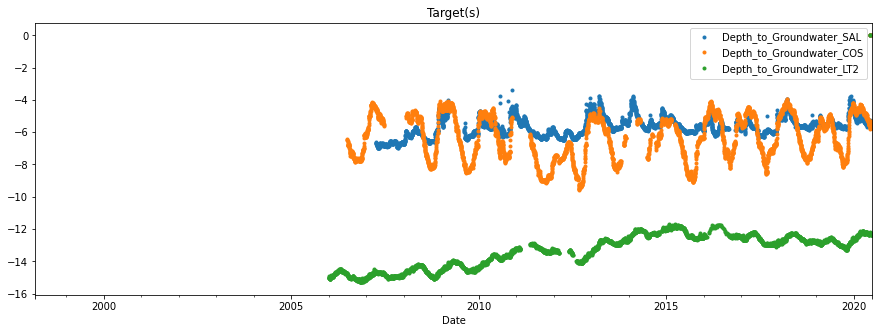

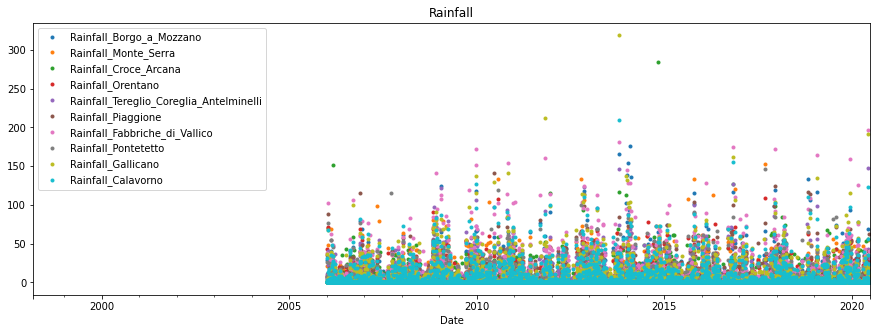

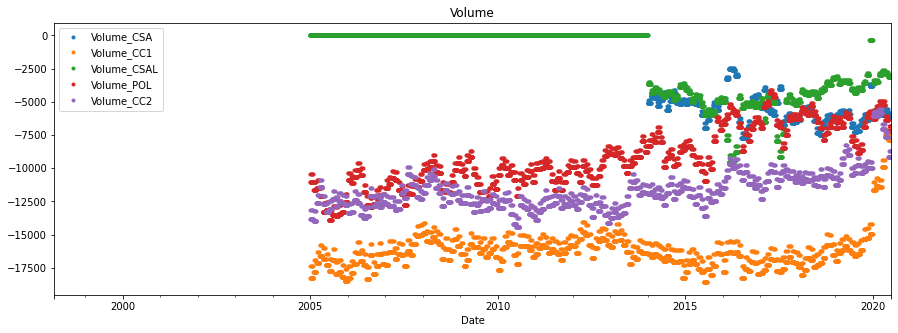

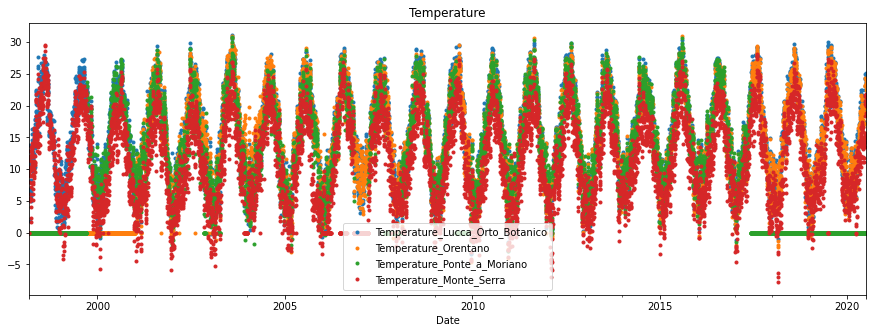

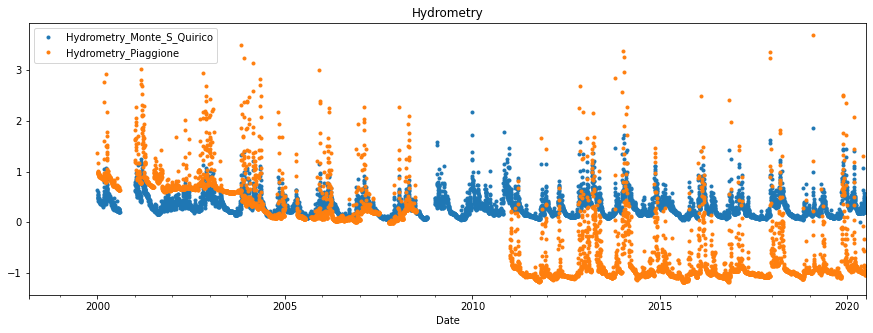

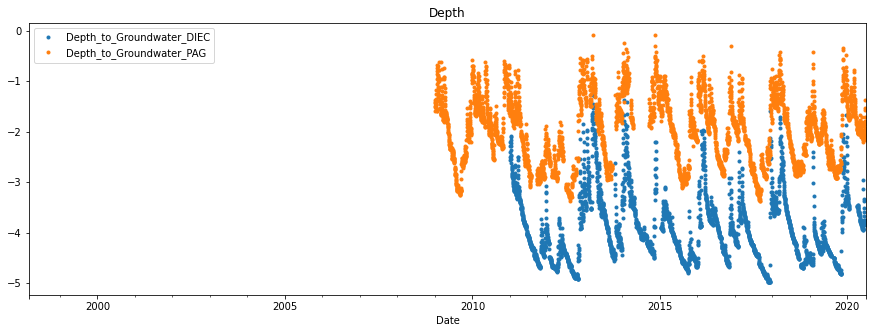

In [110]:
name = names[0]
print(name)
inspect_water_body(name, df_descr, dfs)


#### Correlations per feature type

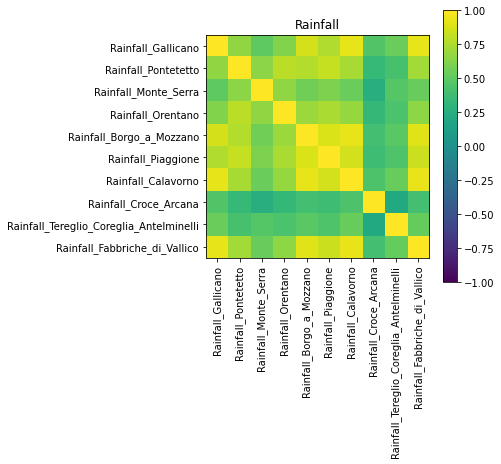

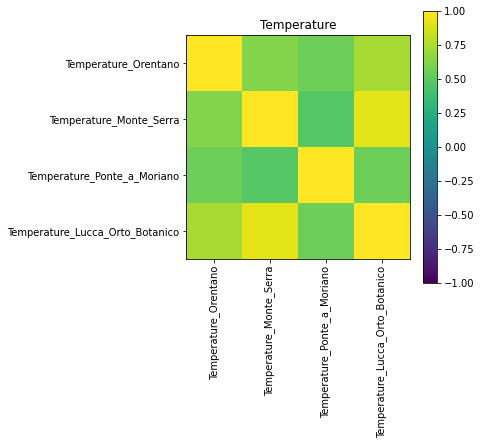

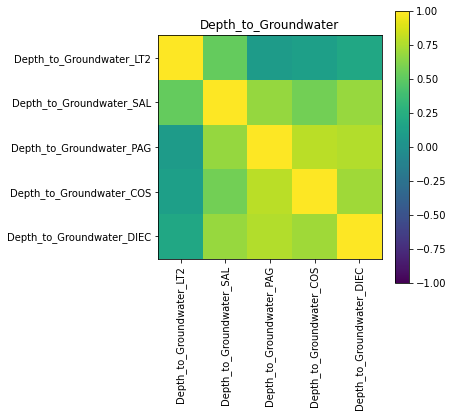

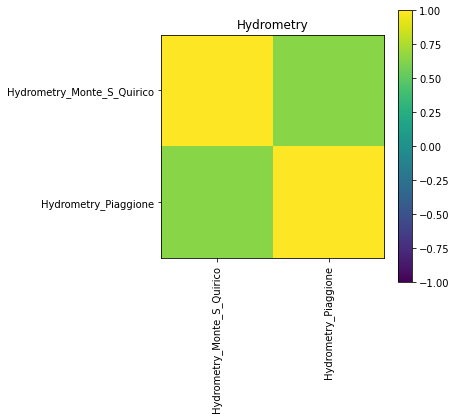

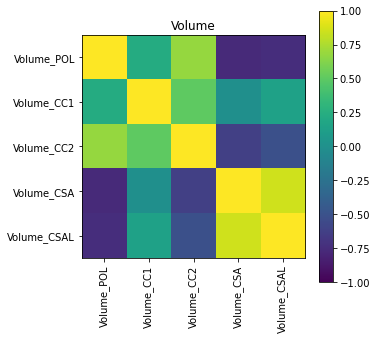

In [80]:
plot_correlation_matrices(dfs[name])

#### Further inspection target

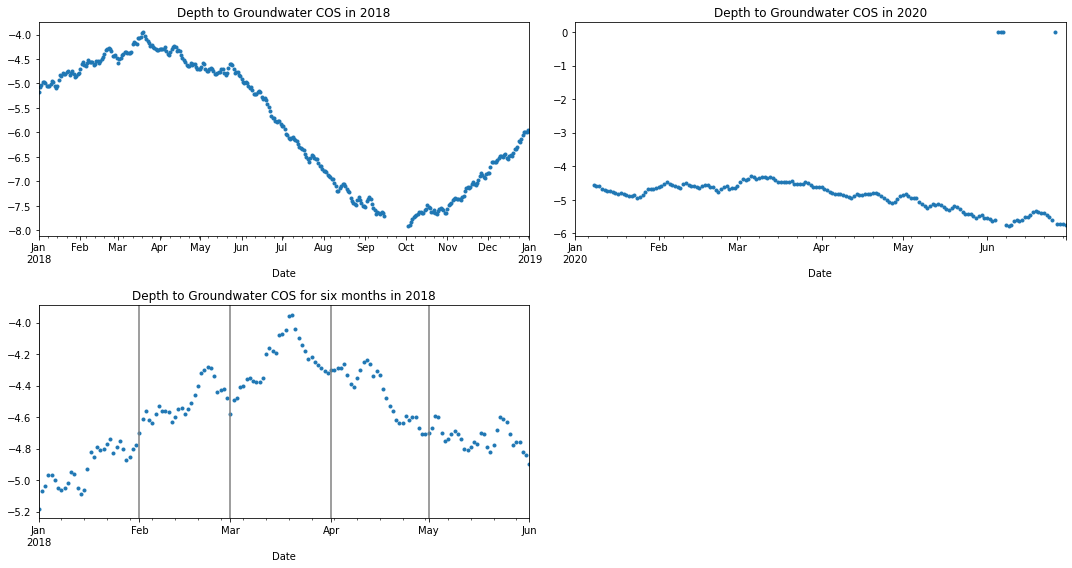

In [81]:
col = 'Depth_to_Groundwater_COS'
inspect_yearly_monthly_pattern(name, dfs, col)

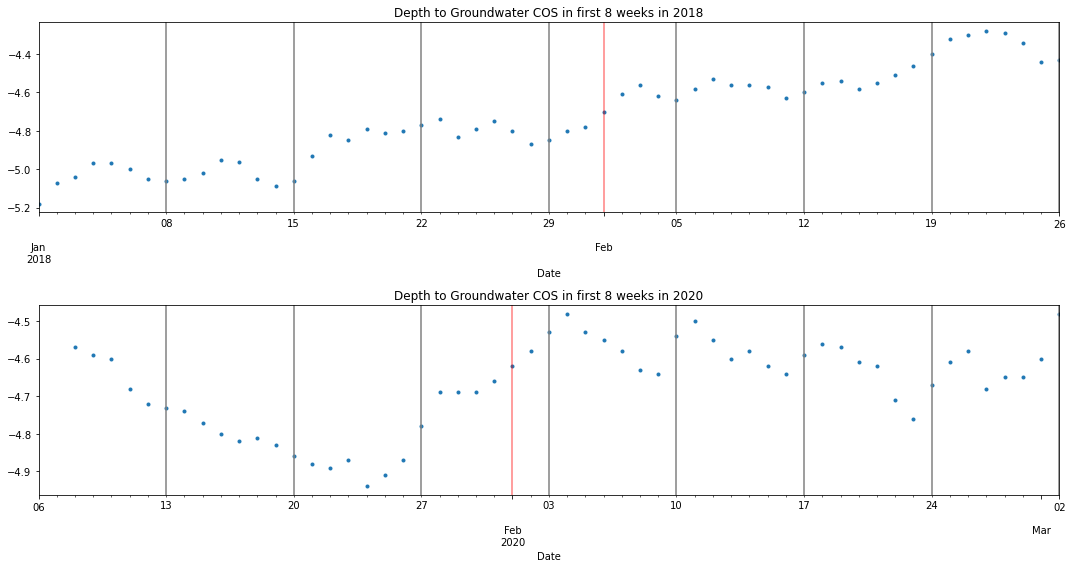

In [82]:
col = 'Depth_to_Groundwater_COS'
inspect_monthly_weekly_pattern(name, dfs, col)

Text(0.5, 1.0, 'Depth to Groundwater SAL')

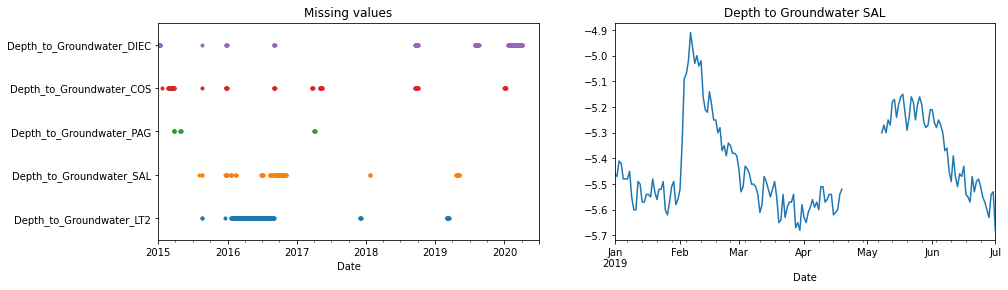

In [83]:
cols = ['Depth_to_Groundwater_LT2',
       'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
       'Depth_to_Groundwater_COS', 'Depth_to_Groundwater_DIEC']

fig = plt.figure(figsize=(15,4))

fig.add_subplot(1,2,1)
for i, c in enumerate(cols):
    (dfs[name].set_index('Date').loc['2015-01-01':][c].isnull().astype(int)*(i+1)).plot(linestyle='', marker='.')
ax = plt.gca()
ax.set_yticks(range(1, len(cols)+1))
labels = ax.set_yticklabels(cols)
plt.ylim(0.5, 5.5)
plt.title('Missing values')

fig.add_subplot(1,2,2)
col = 'Depth_to_Groundwater_SAL'
dfs[name].set_index('Date')[col].loc['2019-01-01':'2019-07-01'].plot()
plt.title(col.replace('_',' '))



#### Futher inspection Volume

- volume constant throughout the month
- weekly peaks?

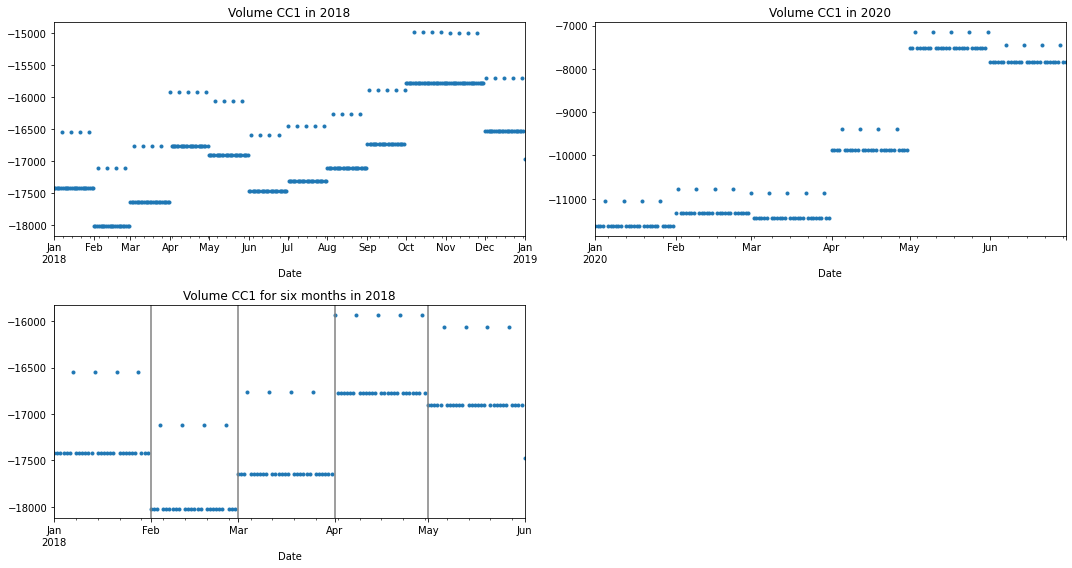

In [84]:
col = 'Volume_CC1'
inspect_yearly_monthly_pattern(name, dfs, col)

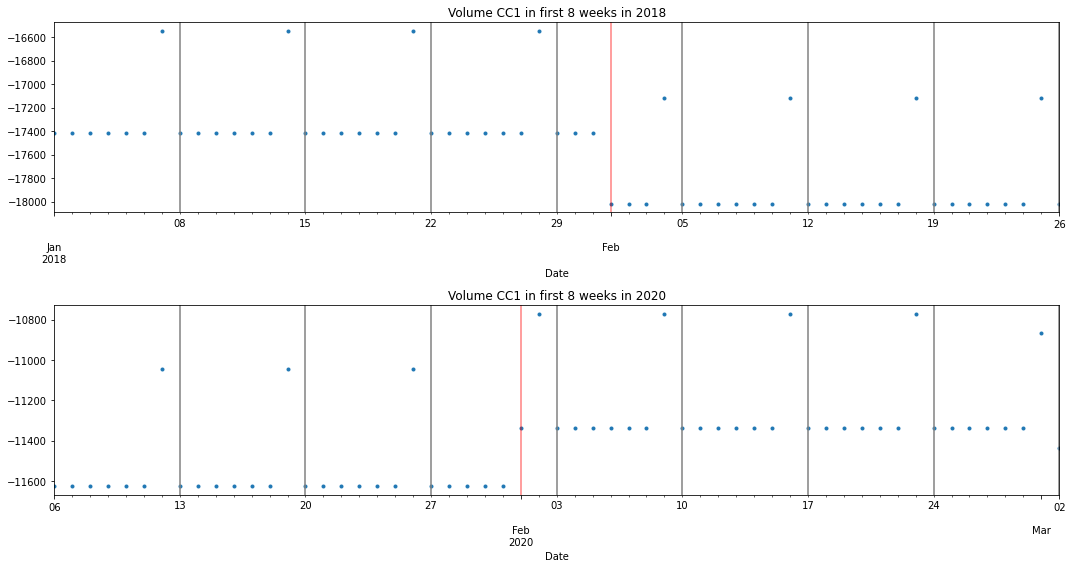

In [85]:
col = 'Volume_CC1'
inspect_monthly_weekly_pattern(name, dfs, col)

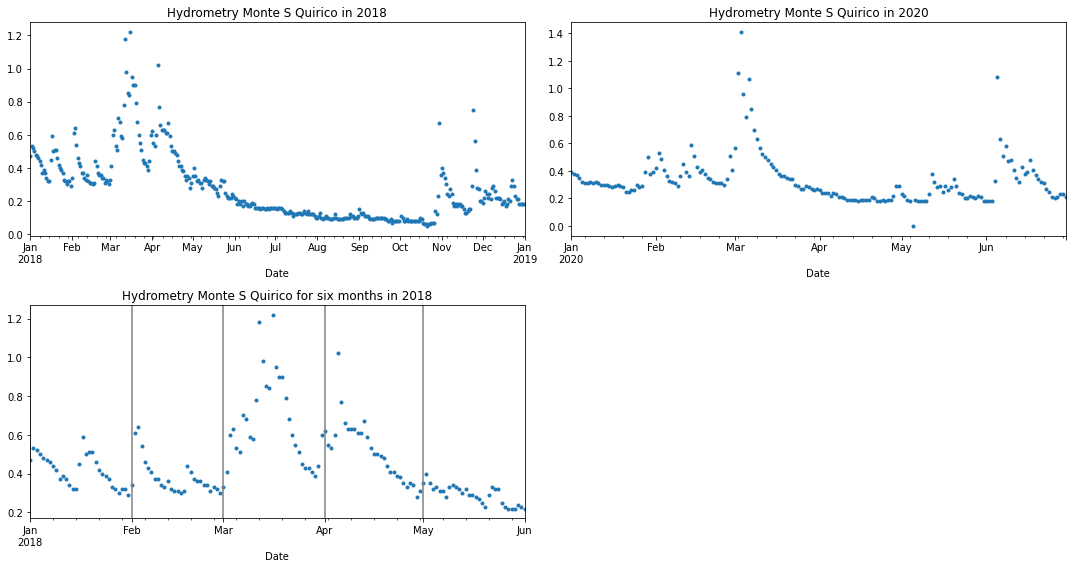

In [86]:
col = 'Hydrometry_Monte_S_Quirico'
inspect_yearly_monthly_pattern(name, dfs, col)

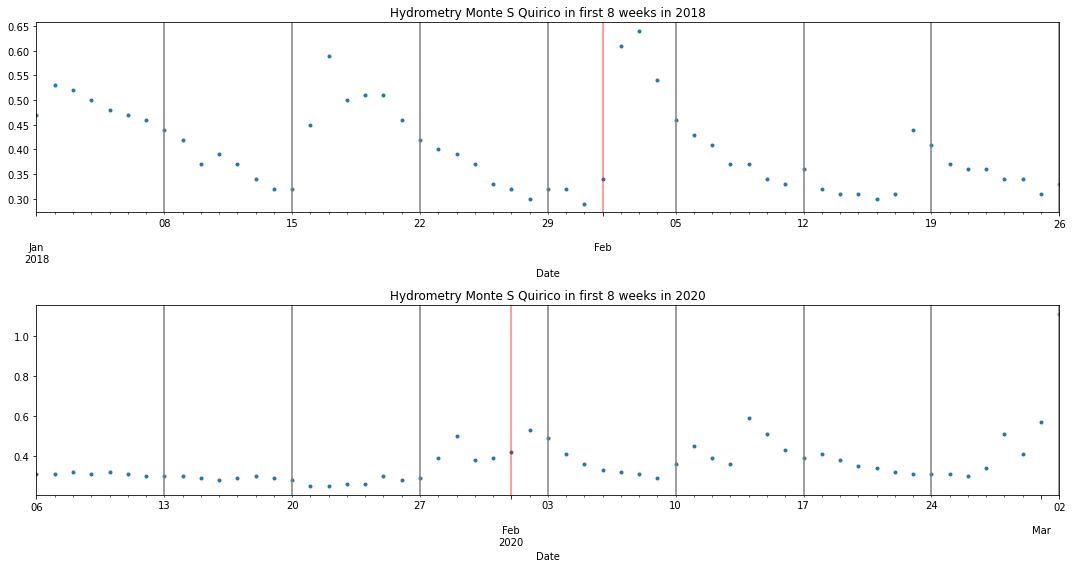

In [87]:
col = 'Hydrometry_Monte_S_Quirico'
inspect_monthly_weekly_pattern(name, dfs, col)

##### Offset in hydtometry readings after 2011

In [124]:
print('min value Monte_S_Quirico after 2010:', dftmp.set_index('Date')['Hydrometry_Monte_S_Quirico'].loc['2010-02-02':].min())
print('min value Piaggione       after 2010:', dftmp.set_index('Date')['Hydrometry_Piaggione'].loc['2010-02-02':].min())

min value Monte_S_Quirico after 2010: 0.0
min value Piaggione       after 2010: -1.19


<AxesSubplot:xlabel='Date'>

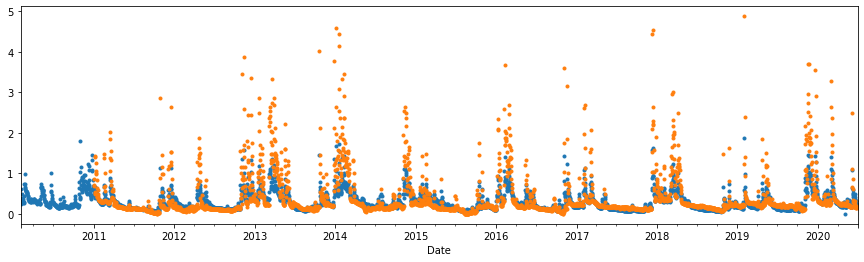

In [123]:
dftmp = dfs[name]
dftmp.set_index('Date')['Hydrometry_Monte_S_Quirico'].loc['2010-02-02':].plot(figsize=(15,4), marker='.', linestyle='')
(dftmp.set_index('Date')['Hydrometry_Piaggione']+1.19).loc['2010-02-02':].plot(figsize=(15,4), marker='.', linestyle='')

### Aquifer Petrignano

Montly pattern, presumably caused by human interventions

**Targets**
- Yearly pattern

**Features**
- Invalid readins in 2015 two features. As not all readings in this period are invalid it might be possible to interpolate
  - Temperature Petrignano
  - Hydrometry Fiume Chiasco Petrignano
  - Outliers in Volume_C10_petrignano
   
**Correlations**
- Temperature
  - very much correlated
  - suggest to contruct 1 feature
- Depth to groundwater
  - Extremely correlated
  
**Data availability for** 
 - 2016 to 2020
 - 2009 to 2020 if it is possible to impute correct values for invalid data in 2015


Aquifer_Petrignano


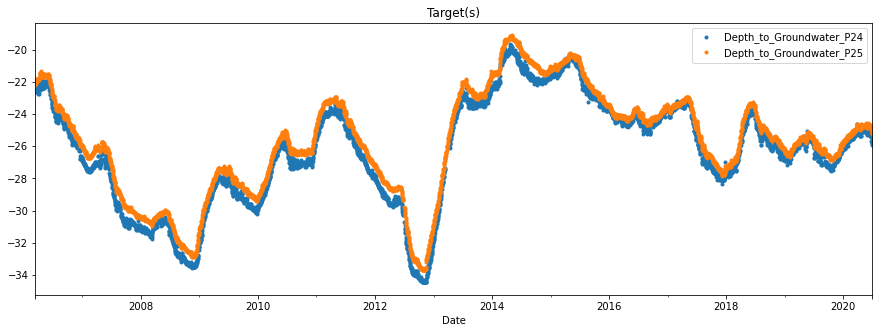

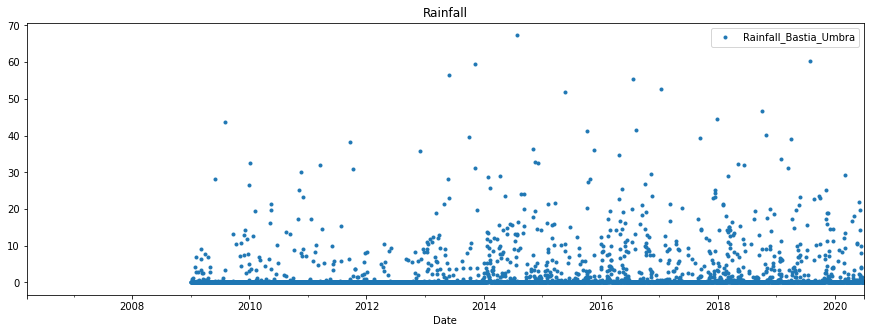

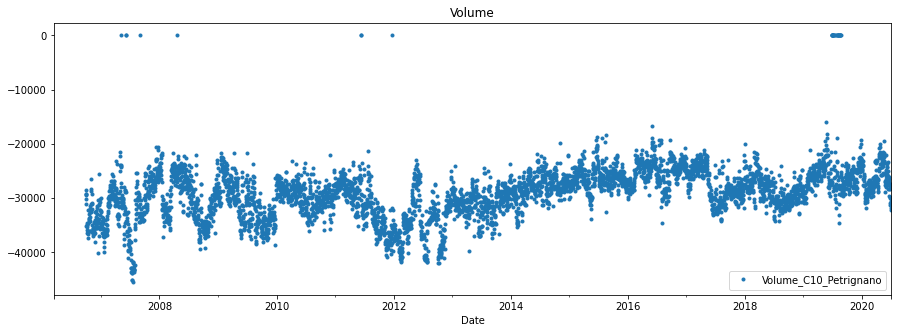

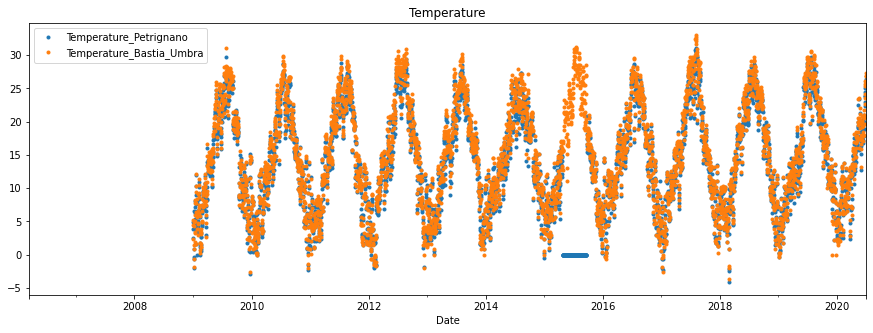

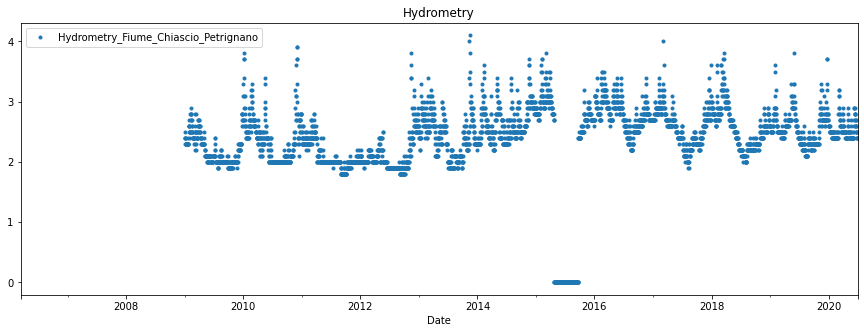

In [125]:
name = names[3]
print(name)
inspect_water_body(name, df_descr, dfs, save=True)


#### Correlations between features of the same sort

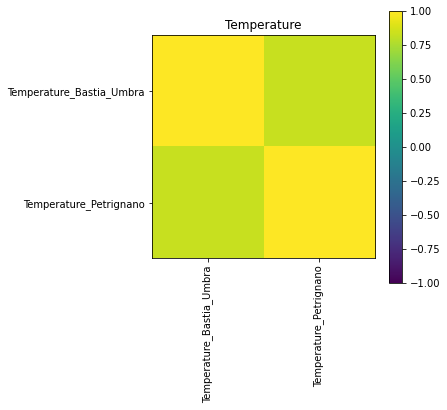

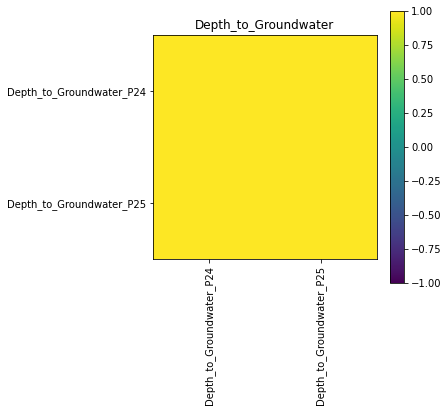

In [89]:
plot_correlation_matrices(dfs[name])

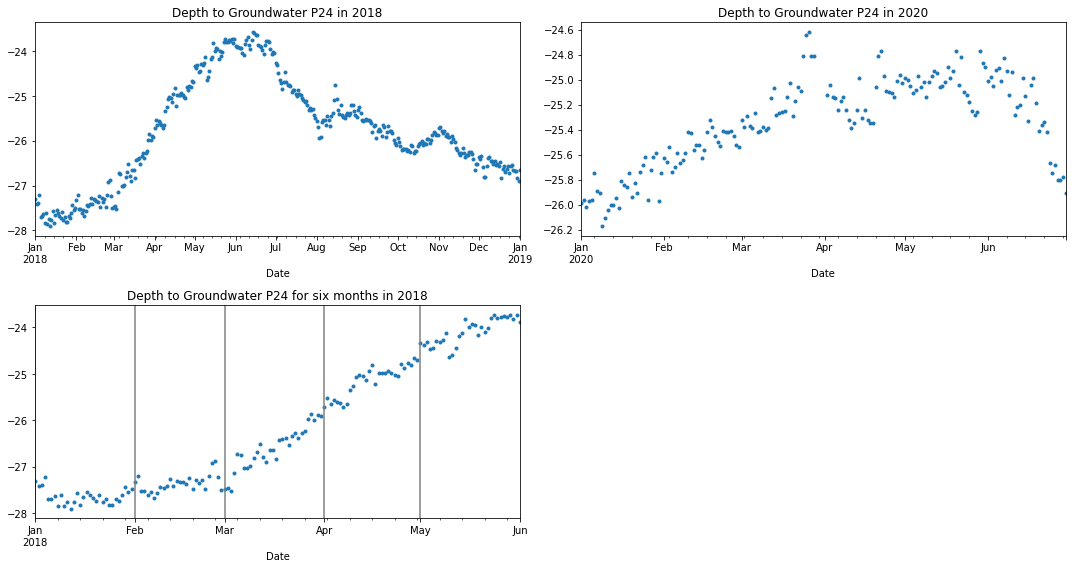

In [90]:
col = 'Depth_to_Groundwater_P24'
inspect_yearly_monthly_pattern(name, dfs, col)

##### Inspect temperature

- what are these 'outliers' in the temperature?
- they seem to occur in a monthly pattern

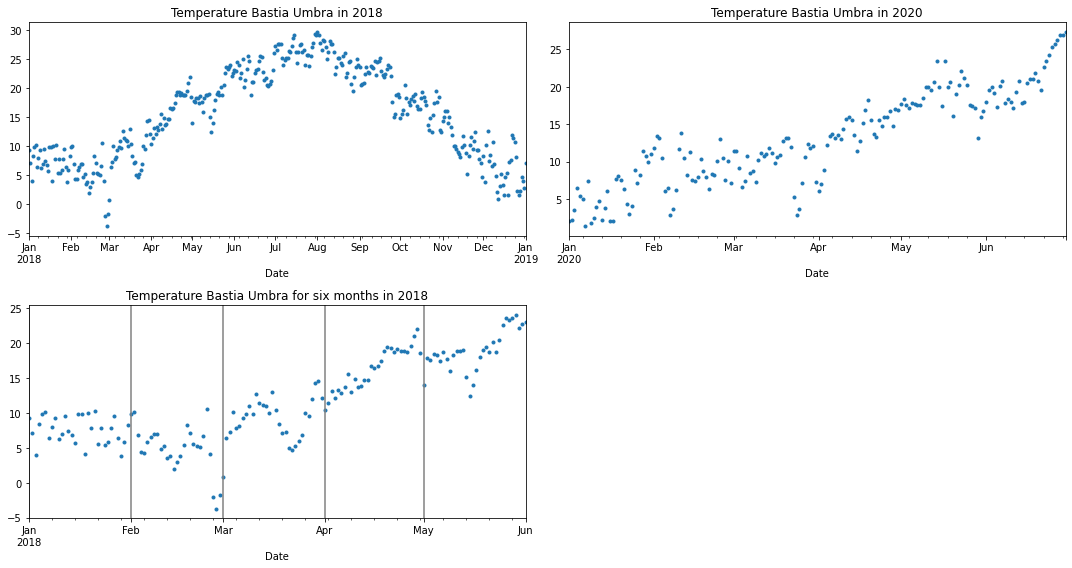

In [91]:
col = 'Temperature_Bastia_Umbra'
inspect_yearly_monthly_pattern(name, dfs, col)

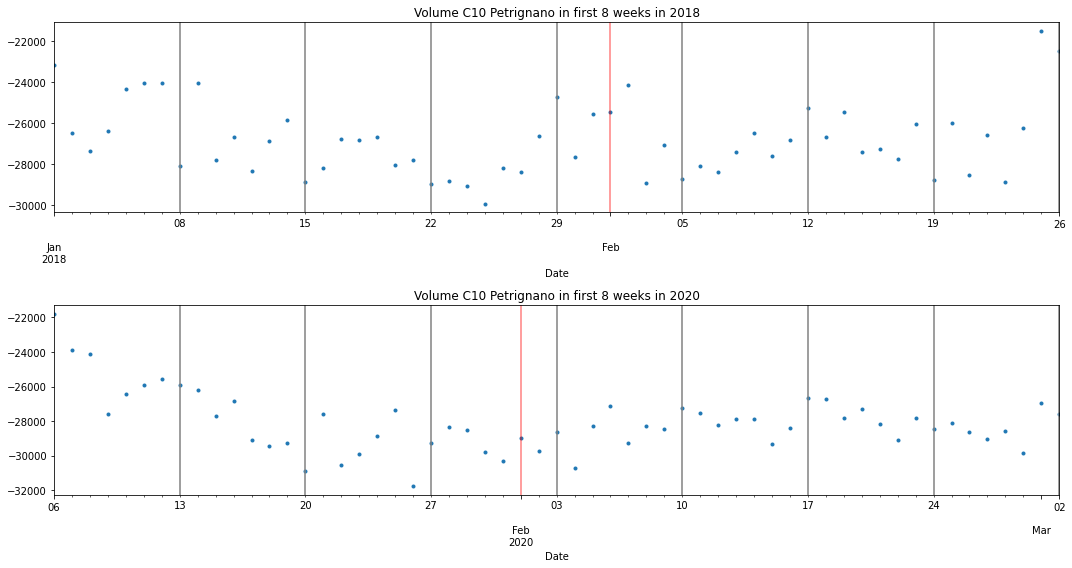

In [92]:
col = 'Volume_C10_Petrignano'
inspect_monthly_weekly_pattern(name, dfs, col)

### River Arno

**target**
- Some zero Hydrometry readings for the target. These seem invalid. 

**features**
- No recent temperature data available
- Only 5 rainfall features still available, data collection in other rainfall features has ceased years ago

**Correlations**

- Rainfall
  - two groups of highly correlated features are identified
  - ['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata',
       'Rainfall_Mangona', 'Rainfall_S_Piero', 'Rainfall_Vernio']
  - ['Rainfall_Stia', 'Rainfall_Consuma', 'Rainfall_Incisa',
       'Rainfall_Montevarchi', 'Rainfall_S_Savino', 'Rainfall_Laterina',
       'Rainfall_Bibbiena', 'Rainfall_Camaldoli']     -- note that all this measurements are unavailble of recent dates!

**Data availability** 
- 2004 to mid 2020, excluding the majority of 2018 where the target is unavailable



River_Arno


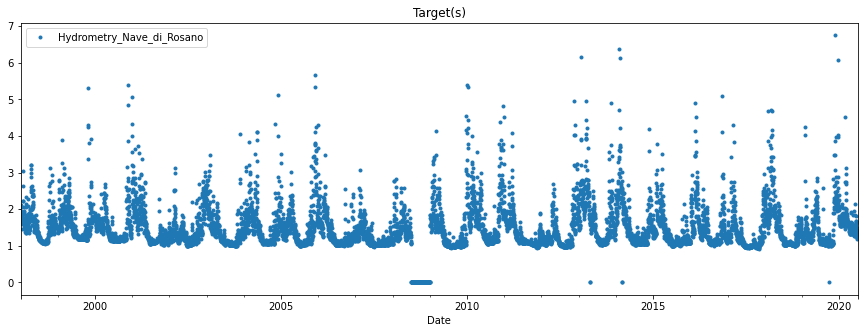

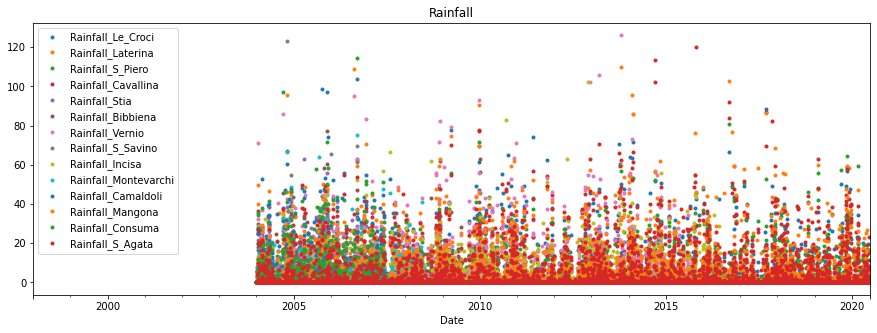

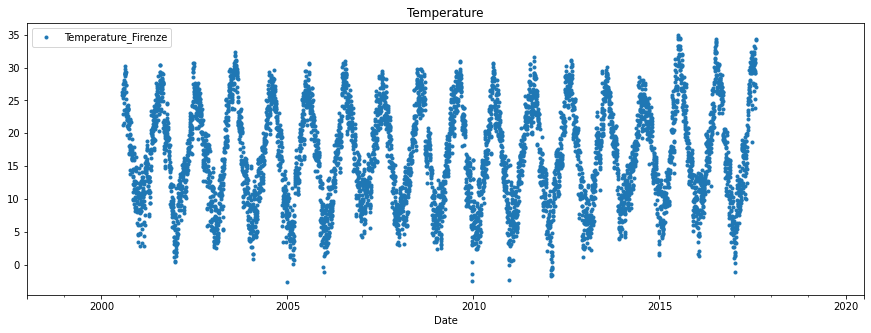

In [140]:
name = names[5]
print(name)
inspect_water_body(name, df_descr, dfs)


In [ ]:
#plot_matrix(values, labels, title, vmin=0, vmax=1, save=False)

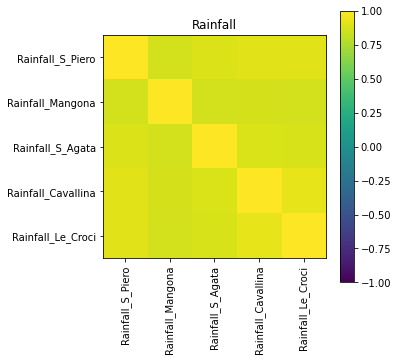

In [153]:
tmp_corr =  dfs[name].filter(regex='^Rainfall').corr()
plot_matrix(tmp_corr, tmp_corr.columns, 'Rainfall', vmin=-1, save=True)

#### Correlations between features of the same sort

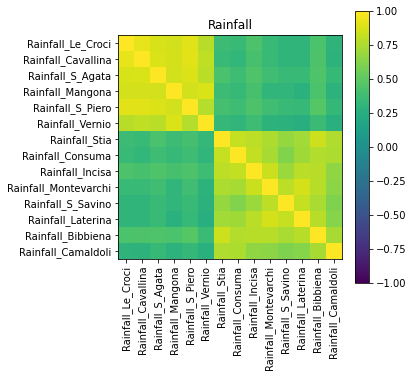

In [95]:
plot_correlation_matrices(dfs[name])

### Further inspact target

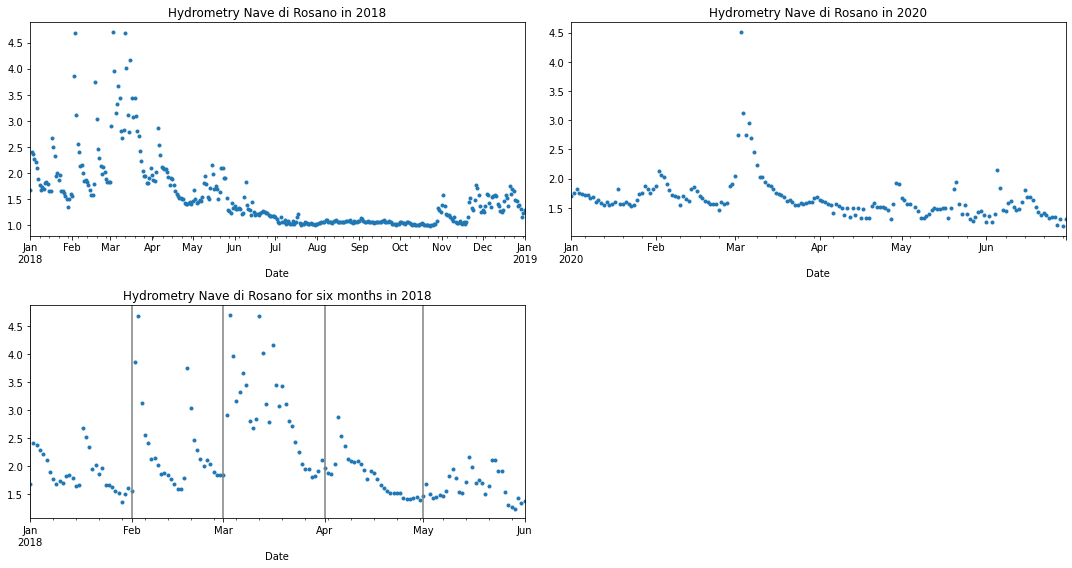

In [96]:
col = 'Hydrometry_Nave_di_Rosano'
inspect_yearly_monthly_pattern(name, dfs, col)

#### Further inspect rainfall

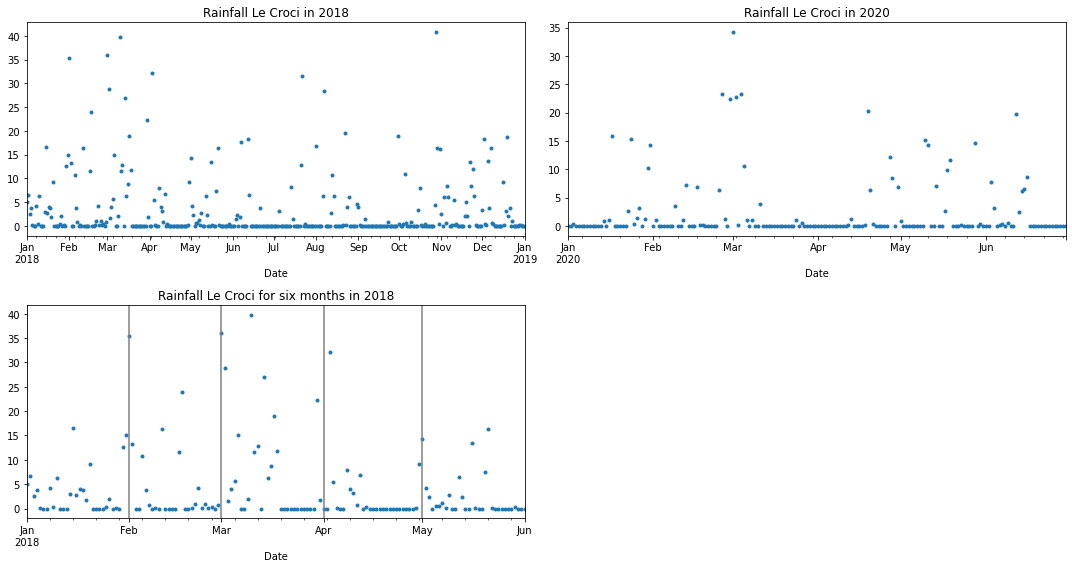

In [97]:
col = 'Rainfall_Le_Croci'
inspect_yearly_monthly_pattern(name, dfs, col)

### Lake Bilancino

**Features**
- flow rate (target) suspiciously constant troughout months-long periods. Maybe flow is controlled with a water lock?

**Correlations**

- Rainfall
  - all features are strongly correlated

**data availability**
-  from 2004 to 2020


Lake_Bilancino


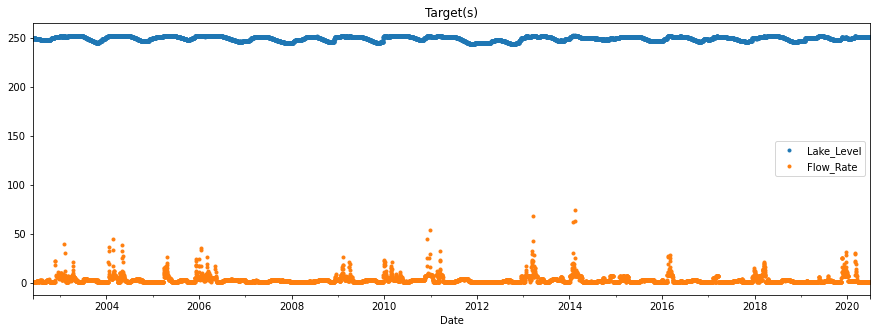

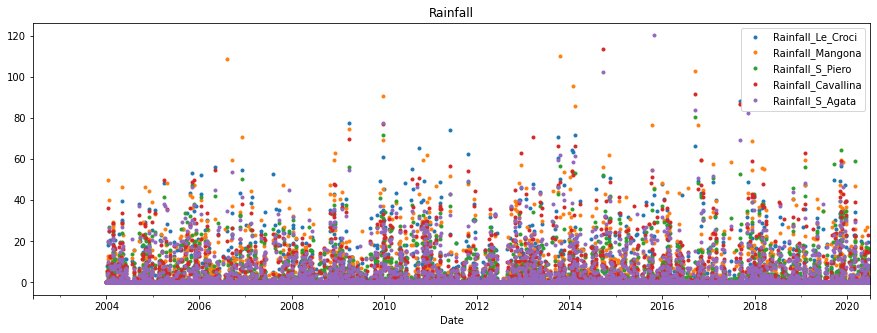

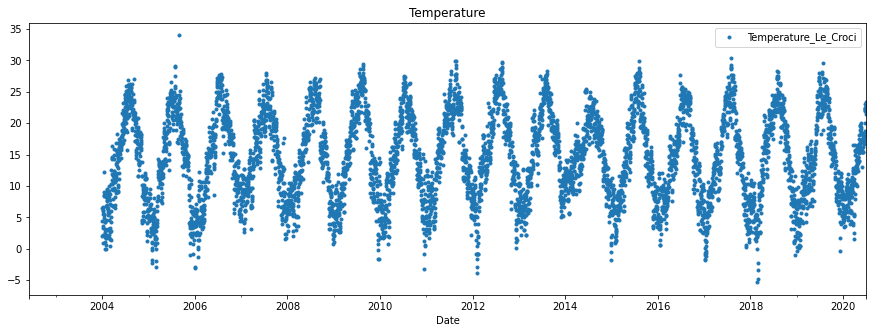

In [146]:
name = names[4]
print(name)
inspect_water_body(name, df_descr, dfs)


#### Correlations between features of the same sort

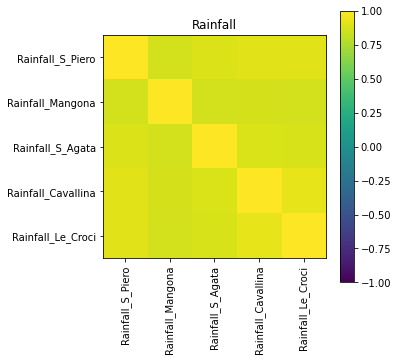

In [99]:
plot_correlation_matrices(dfs[name])

#### Further inspect targets

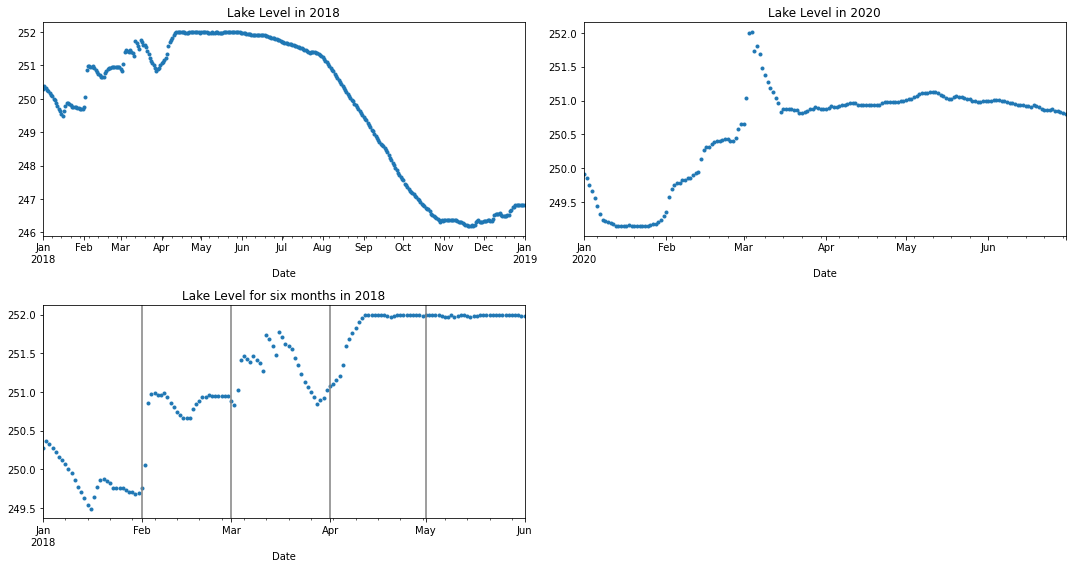

In [100]:
col = 'Lake_Level'
inspect_yearly_monthly_pattern(name, dfs, col)

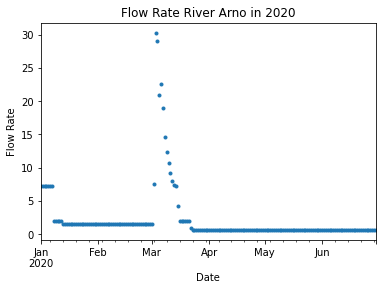

In [154]:
dfs[name].set_index('Date').loc['2020-01-01':]['Flow_Rate'].plot(marker='.', linestyle='')
plt.title('Flow Rate River Arno in 2020')
plt.ylabel('Flow Rate')
plt.savefig('figs/River_Arno_Flow_Rate_2020.pdf')


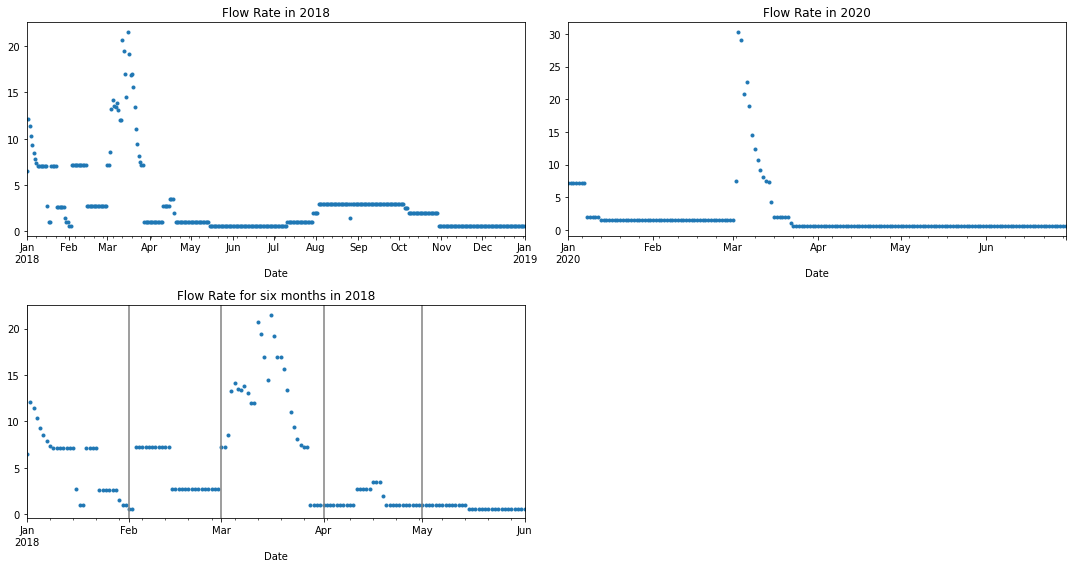

In [101]:
col = 'Flow_Rate'
inspect_yearly_monthly_pattern(name, dfs, col)

### Water spring amiata

- data from 2015 to 2020
- flow rates (targets) seem to be fixed per month. Offset on each Sunday.
- Flow_Rate_Arubre is 0 for some periods. Not sure whether this is really 0 or a false measurement

<font color='red'> Unclear whether this concerns a water spring or an aquifer! </font>

In [102]:
print('name = ', name)
print('')
print('description = ', df_descr.set_index('Database').loc[names[6], 'Description'])

name =  Lake_Bilancino

description =  Information about the Amiata aquifer. This aquifer is accessed through the Ermicciolo, Arbure, Bugnano and Galleria Alta springs. 
The levels and volumes of the four springs are influenced by the parameters: pluviometry, sub-gradation, hydrometry, temperatures and drainage volumes.


Water_Spring_Amiata


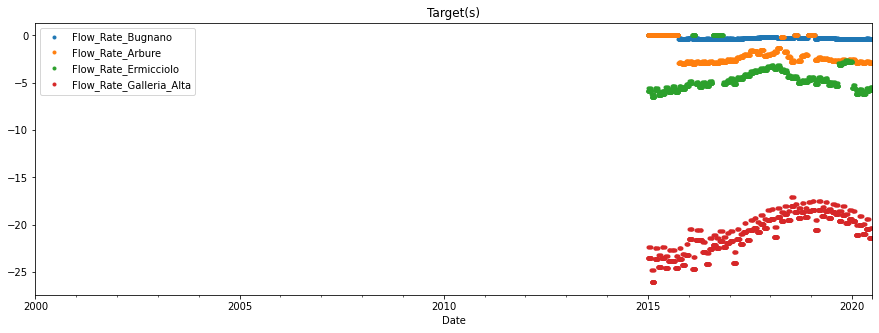

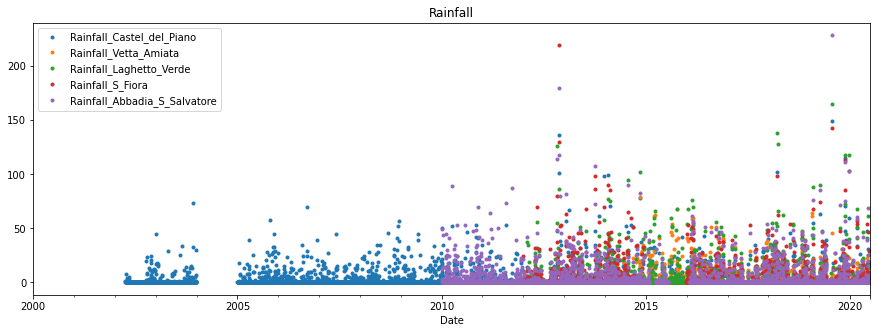

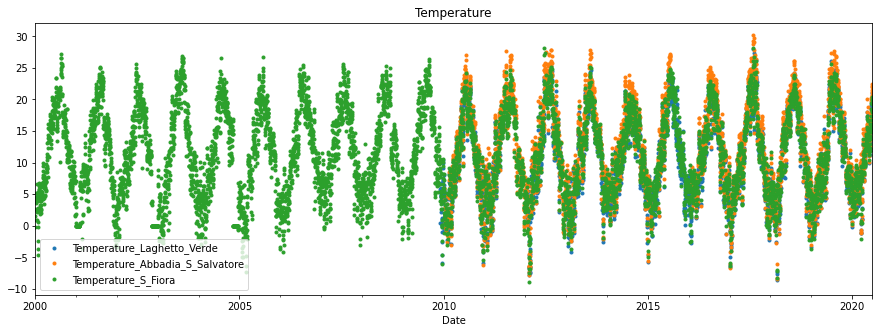

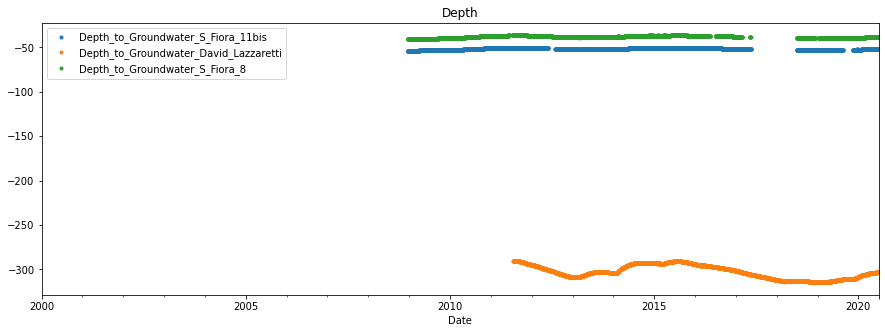

In [103]:
name = names[6]
print(name)
inspect_water_body(name, df_descr, dfs)


#### Correlations between features of the same sort

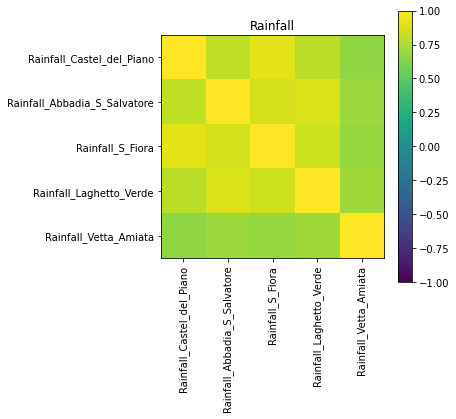

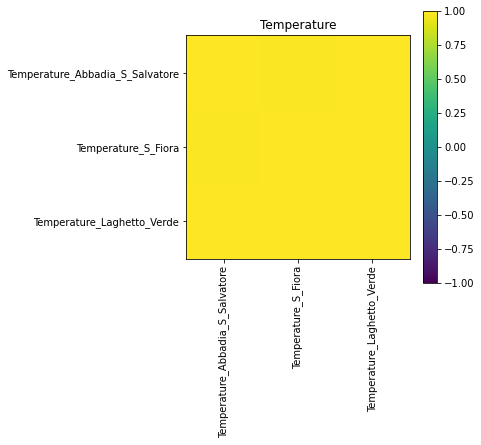

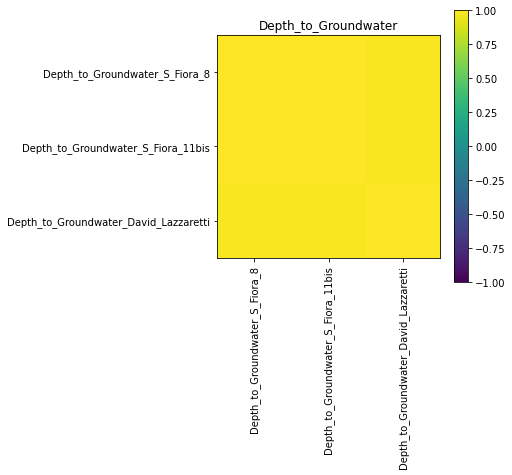

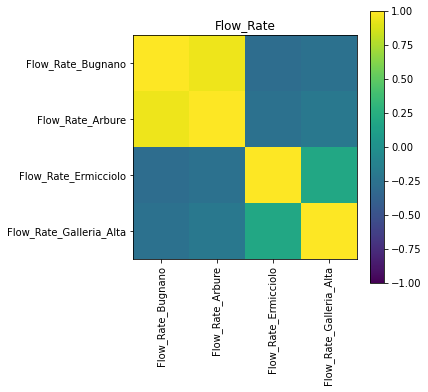

In [104]:
plot_correlation_matrices(dfs[name])

#### Further inspect targets

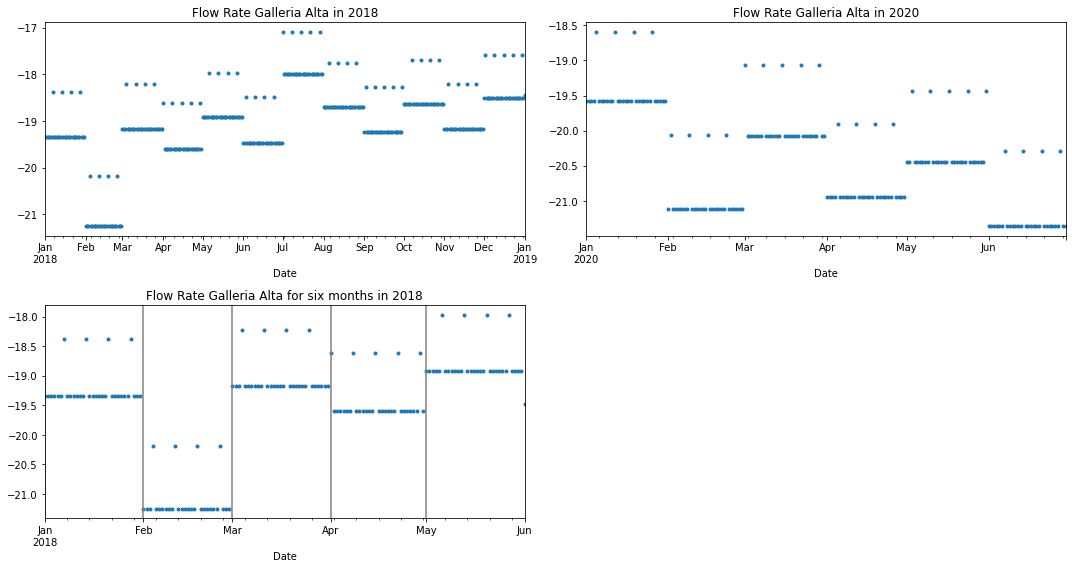

In [105]:
col = 'Flow_Rate_Galleria_Alta'
inspect_yearly_monthly_pattern(name, dfs, col)

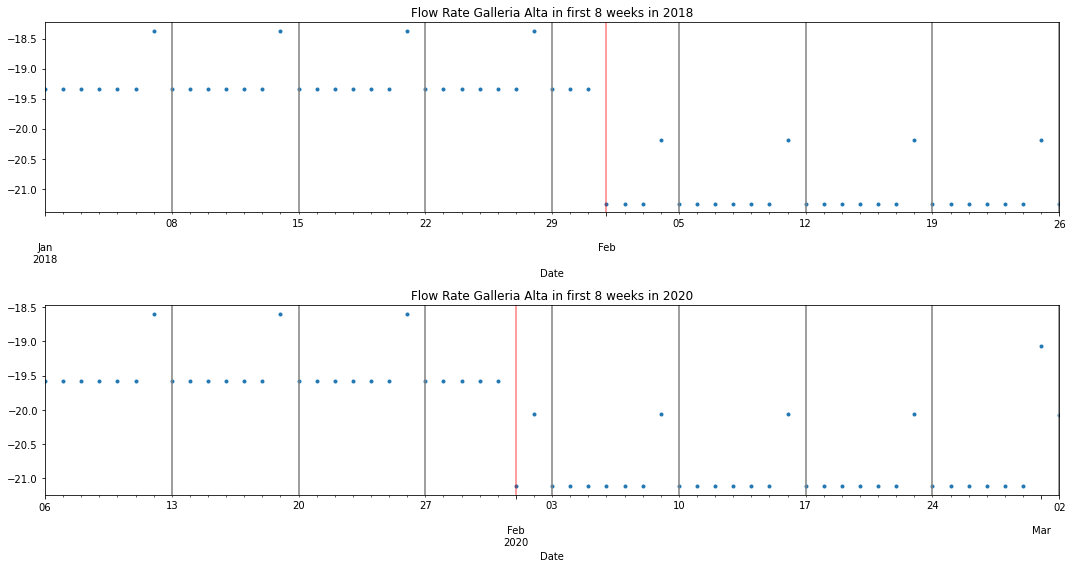

In [106]:
col = 'Flow_Rate_Galleria_Alta'
inspect_monthly_weekly_pattern(name, dfs, col)

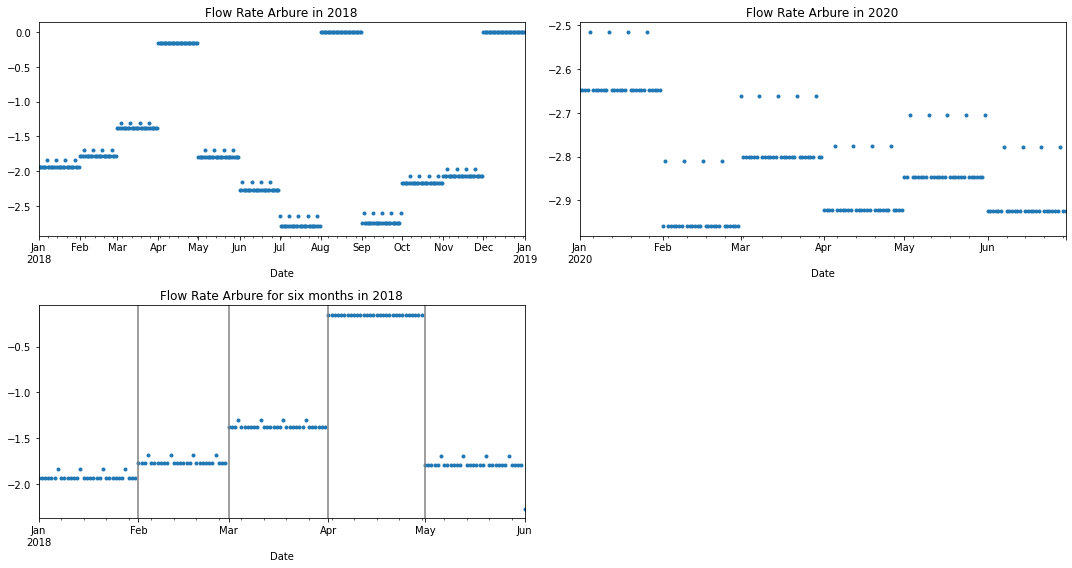

In [107]:
col = 'Flow_Rate_Arbure'
inspect_yearly_monthly_pattern(name, dfs, col)

In [728]:
dfs[name][dfs[name]['Flow_Rate_Arbure']>-1.5]['Flow_Rate_Arbure'].value_counts()

 0.000000    366
-1.375827     27
-0.158437     25
-0.150515      5
-1.307036      4
Name: Flow_Rate_Arbure, dtype: int64